In [1]:
"""
references: 
    https://www.tensorflow.org/get_started/mnist/mechanics
    https://github.com/tensorflow/tensorflow/tree/r1.2/tensorflow/examples/tutorials/mnist

The goal of this tutorial is to show how to use TensorFlow to train and evaluate a simple 
feed-forward neural network for handwritten digit classification using the (classic) MNIST data set. 

"""

import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from __future__ import print_function

import os.path
import sys
import time

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from tensorflow.examples.tutorials.mnist import input_data
#from tensorflow.examples.tutorials.mnist import mnist

# Environments

In [2]:
"""
Please note, the environments for the codes.
"""

import platform

print(platform.linux_distribution())

print(platform.python_version())

print(tf.__version__)

print(np.__version__)

('Ubuntu', '14.04', 'trusty')
2.7.6
1.0.1
1.12.1


# Load Data

In [3]:
mnist = input_data.read_data_sets('./mnist', one_hot=False)

Extracting ./mnist/train-images-idx3-ubyte.gz
Extracting ./mnist/train-labels-idx1-ubyte.gz
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz


In [5]:
print(type(mnist))
print(type(mnist.train))


print(mnist.train.images.shape)
print(mnist.train.labels.shape)

<class 'tensorflow.contrib.learn.python.learn.datasets.base.Datasets'>
<class 'tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet'>
(55000, 784)
(55000,)


In [4]:
img =  mnist.train.images[np.random.randint(0, 55000, size = 100), :].reshape(-1, 28, 28)

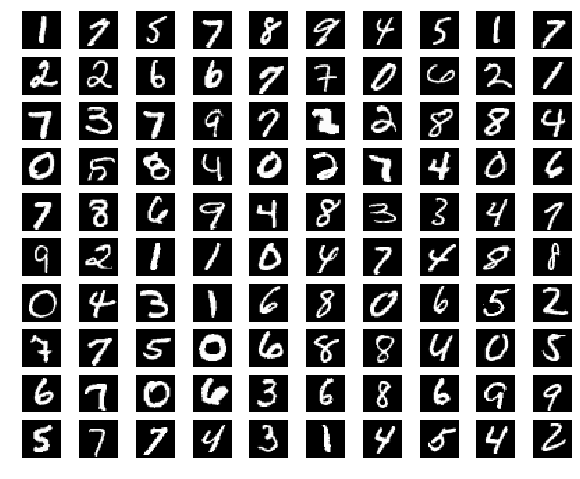

In [5]:
## refer to stanford cs231n assignment2 for the imshow_noax()
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')
    
for i in range(10):
    for j in range(10):
        plt.subplot(10, 10, i * 10 + j + 1)
        imshow_noax(img[i * 10 + j, :])
plt.show()

# Model

In [2]:
## refer to :https://github.com/tensorflow/tensorflow/blob/r1.2/tensorflow/examples/tutorials/mnist/mnist.py

NUM_CLASSES  = 10
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE

## two layer fc network
def inference(images, hidden_dim1, hidden_dim2):
    """
    Args:
        images: images placeholder
        hidden_dim1: size of the first hidden layer
        hidden_dim2: size of the second hidden layer
        
    Returns:
        output tensor logits for the softmax
       
    """
    ##  hidden layer1
    with tf.name_scope('hidden1'):
        weights = tf.Variable(tf.truncated_normal([IMAGE_PIXELS, hidden_dim1], 
                                                  stddev = 1.0 /math.sqrt(float(IMAGE_PIXELS))), name = 'weights')
        biases = tf.Variable(tf.zeros([hidden_dim1]), name = 'biases')
        
        hidden1 = tf.nn.relu(tf.matmul(images, weights) + biases)
        
    ## hidden layer2
    with tf.name_scope('hidden2'):
        weights = tf.Variable(tf.truncated_normal([hidden_dim1, hidden_dim2], 
                                                  stddev = 1.0 /math.sqrt(float(hidden_dim1))), name = 'weights')
        biases = tf.Variable(tf.zeros([hidden_dim2]), name = 'biases')
        
        hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)
        
    ## affine layer3
    with tf.name_scope('linear_softmax'):
        weights = tf.Variable(tf.truncated_normal([hidden_dim2, NUM_CLASSES], 
                                                  stddev = 1.0 /math.sqrt(float(hidden_dim2))), name = 'weights')
        biases = tf.Variable(tf.zeros([NUM_CLASSES]), name = 'biases')
        
        logits = tf.matmul(hidden2, weights) + biases
        
    return logits
    

## cross entropy loss
def loss(logits, labels):
    """
    Args:
        logits: Logits tensor, float -[batch_size, NUM_CLASSES]
        labels: Labels tensor, int32 -[batch_size],   NOT ONE HOT
        
    Returns:
        loss: Loss tensor of type float    
    """
    
    labels = tf.to_int64(labels)
    
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels, logits = logits, name = 'xentropy')
    mean_loss = tf.reduce_mean(loss, name = 'xentropy_mean')
    
    return mean_loss
        
def training(loss, learining_rate):
    """
    Sets up the training Ops.
        Creates a summarizer to track the loss over time in TensorBoard.
 
    Args:
        loss: Loss tensor, from loss().
        learning_rate: The learning rate to use for gradient descent.
    Returns:
        train_op: The Op for training.
    """
    ## TensorBoard: add a scalar summary for the snapshot loss
    tf.summary.scalar('loss', loss)
    
    optimizer = tf.train.GradientDescentOptimizer(learining_rate)
    
    global_step = tf.Variable(0, name = 'global_step', trainable = False)
    
    train_op = optimizer.minimize(loss, global_step = global_step)
    
    return train_op


def evaluation(logits, labels):
    """
    Args:
        logits: Logits tensor, float - [batch_size, NUM_CLASSES]
        labels: labels tensor, int32 - [batch_size], in the range [0, NUM_CLASSES)
    
    Returns:
        A scalar int32 tensor
   
    """
    correct = tf.nn.in_top_k(logits, labels, 1)

    
    return tf.reduce_sum(tf.cast(correct, tf.int32))    

# Train and Evaluate

In [38]:
## refer to 
## https://github.com/tensorflow/tensorflow/blob/r1.2/tensorflow/examples/tutorials/mnist/fully_connected_feed.py

class configs:
    batch_size = 100
    hidden_dim1 = 64
    hidden_dim2 = 32
    learning_rate = 5e-1
    log_dir = './fc_logs'
    max_steps = 2000
    fake_data = False
    input_data_dir = './mnist'
    

FLAGS = configs

def placeholder_inputs(batch_size):
    """
    A function to generate placeholder variables for the input tensors
    
    Args:
        batch_size
        
    Returns:
        images_placeholder:  input image placeholder
        labels_placeholder:  input image labels placeholder    
    """
    
    images_placeholder = tf.placeholder(tf.float32, shape = [batch_size, IMAGE_PIXELS])
    labels_placeholder = tf.placeholder(tf.int32, shape = [batch_size])
    
    return images_placeholder, labels_placeholder
    
    
def fill_feed_dict(data_set, images_pl, labels_pl):
    """
    Args:
        data_set: The set of images and labels, from input_data.read_data_sets()
        images_pl: images_placeholder from placeholder_inputs()
        labels_pl: labels_placeholder from placeholder_inputs()
        
    Returns:
        feed_dict
       
    """
    images_feed, labels_feed = data_set.next_batch(FLAGS.batch_size, FLAGS.fake_data)
    
    feed_dict = {images_pl: images_feed, labels_pl: labels_feed}
    
    return feed_dict
    
    
def do_eval(sess, 
            eval_correct,
            images_placeholder,
            labels_placeholder,
            data_set):
    
    """
    runs one evaluation against the full epoch of data
    """
    
    true_count = 0  ## counts the number of correct predictions
    steps_per_epoch = data_set.num_examples // FLAGS.batch_size
    ## Mr. Hu: a minor logic bug from fill_feed_dict(), which uses fixed FLAGS.batch_size
    
    num_examples = steps_per_epoch * FLAGS.batch_size
    
    for step in xrange(steps_per_epoch):
        feed_dict = fill_feed_dict(data_set,
                                   images_placeholder,
                                   labels_placeholder)
        true_count += sess.run(eval_correct, feed_dict = feed_dict)
        
    precision = float(true_count) / num_examples
    print(" Num examples: %d  Num correct: %d  Precision @ 1: %0.04f" %
         (num_examples, true_count, precision))
    
    
def run_training():
    """Train MNIST for a number of steps."""
    # Get the sets of images and labels for training, validation, and
    # test on MNIST.
    data_sets = input_data.read_data_sets(FLAGS.input_data_dir, FLAGS.fake_data)
  
    # Tell TensorFlow that the model will be built into the default Graph.
    with tf.Graph().as_default():
        images_placeholder, labels_placeholder = placeholder_inputs(FLAGS.batch_size)


        logits = inference(images_placeholder,
                             FLAGS.hidden_dim1,
                             FLAGS.hidden_dim2)

        # Add to the Graph the Ops for loss calculation.
        mean_loss = loss(logits, labels_placeholder)

        # Add to the Graph the Ops that calculate and apply gradients.
        train_op = training(mean_loss, FLAGS.learning_rate)

        # Add the Op to compare the logits to the labels during evaluation.
        eval_correct = evaluation(logits, labels_placeholder)

        # Build the summary Tensor based on the TF collection of Summaries.
        summary = tf.summary.merge_all()

        # Add the variable initializer Op.
        init = tf.global_variables_initializer()

        # Create a saver for writing training checkpoints.
        saver = tf.train.Saver()

        # Create a session for running Ops on the Graph.
        sess = tf.Session()

        # Instantiate a SummaryWriter to output summaries and the Graph.
        summary_writer = tf.summary.FileWriter(FLAGS.log_dir, sess.graph)

        # And then after everything is built:

        # Run the Op to initialize the variables.
        sess.run(init)

        # Start the training loop.
        for step in xrange(FLAGS.max_steps):
            start_time = time.time()

            # Fill a feed dictionary with the actual set of images and labels
            # for this particular training step.
            feed_dict = fill_feed_dict(data_sets.train,
                                 images_placeholder,
                                 labels_placeholder)

            _, loss_value = sess.run([train_op, mean_loss],
                               feed_dict=feed_dict)

            duration = time.time() - start_time

            # Write the summaries and print an overview fairly often.
            if step % 100 == 0:
                # Print status to stdout.
                print('Step %d: loss = %.2f (%.3f sec)' % (step, loss_value, duration))
                # Update the events file.
                summary_str = sess.run(summary, feed_dict=feed_dict)
                summary_writer.add_summary(summary_str, step)
                summary_writer.flush()

            # Save a checkpoint and evaluate the model periodically.
            if (step + 1) % 1000 == 0 or (step + 1) == FLAGS.max_steps:
                checkpoint_file = os.path.join(FLAGS.log_dir, 'model.ckpt')
                saver.save(sess, checkpoint_file, global_step=step)
                # Evaluate against the training set.
                print('Training Data Eval:')
                do_eval(sess,
                        eval_correct,
                        images_placeholder,
                        labels_placeholder,
                        data_sets.train)
                # Evaluate against the validation set.
                print('Validation Data Eval:')
                do_eval(sess,
                        eval_correct,
                        images_placeholder,
                        labels_placeholder,
                        data_sets.validation)
                # Evaluate against the test set.
                print('Test Data Eval:')
                do_eval(sess,
                        eval_correct,
                        images_placeholder,
                        labels_placeholder,
                        data_sets.test) 
                
        saver.save(sess, "./models/02_fc.ckpt")

# Running

In [39]:
run_training()

Extracting ./mnist/train-images-idx3-ubyte.gz
Extracting ./mnist/train-labels-idx1-ubyte.gz
Extracting ./mnist/t10k-images-idx3-ubyte.gz
Extracting ./mnist/t10k-labels-idx1-ubyte.gz
Step 0: loss = 2.31 (0.007 sec)
Step 100: loss = 0.45 (0.001 sec)
Step 200: loss = 0.26 (0.001 sec)
Step 300: loss = 0.19 (0.001 sec)
Step 400: loss = 0.26 (0.001 sec)
Step 500: loss = 0.10 (0.002 sec)
Step 600: loss = 0.11 (0.002 sec)
Step 700: loss = 0.22 (0.001 sec)
Step 800: loss = 0.08 (0.001 sec)
Step 900: loss = 0.13 (0.001 sec)
Training Data Eval:
 Num examples: 55000  Num correct: 51841  Precision @ 1: 0.9426
Validation Data Eval:
 Num examples: 5000  Num correct: 4737  Precision @ 1: 0.9474
Test Data Eval:
 Num examples: 10000  Num correct: 9380  Precision @ 1: 0.9380
Step 1000: loss = 0.13 (0.001 sec)
Step 1100: loss = 0.18 (0.030 sec)
Step 1200: loss = 0.10 (0.001 sec)
Step 1300: loss = 0.11 (0.001 sec)
Step 1400: loss = 0.18 (0.001 sec)
Step 1500: loss = 0.09 (0.001 sec)
Step 1600: loss = 0.12 

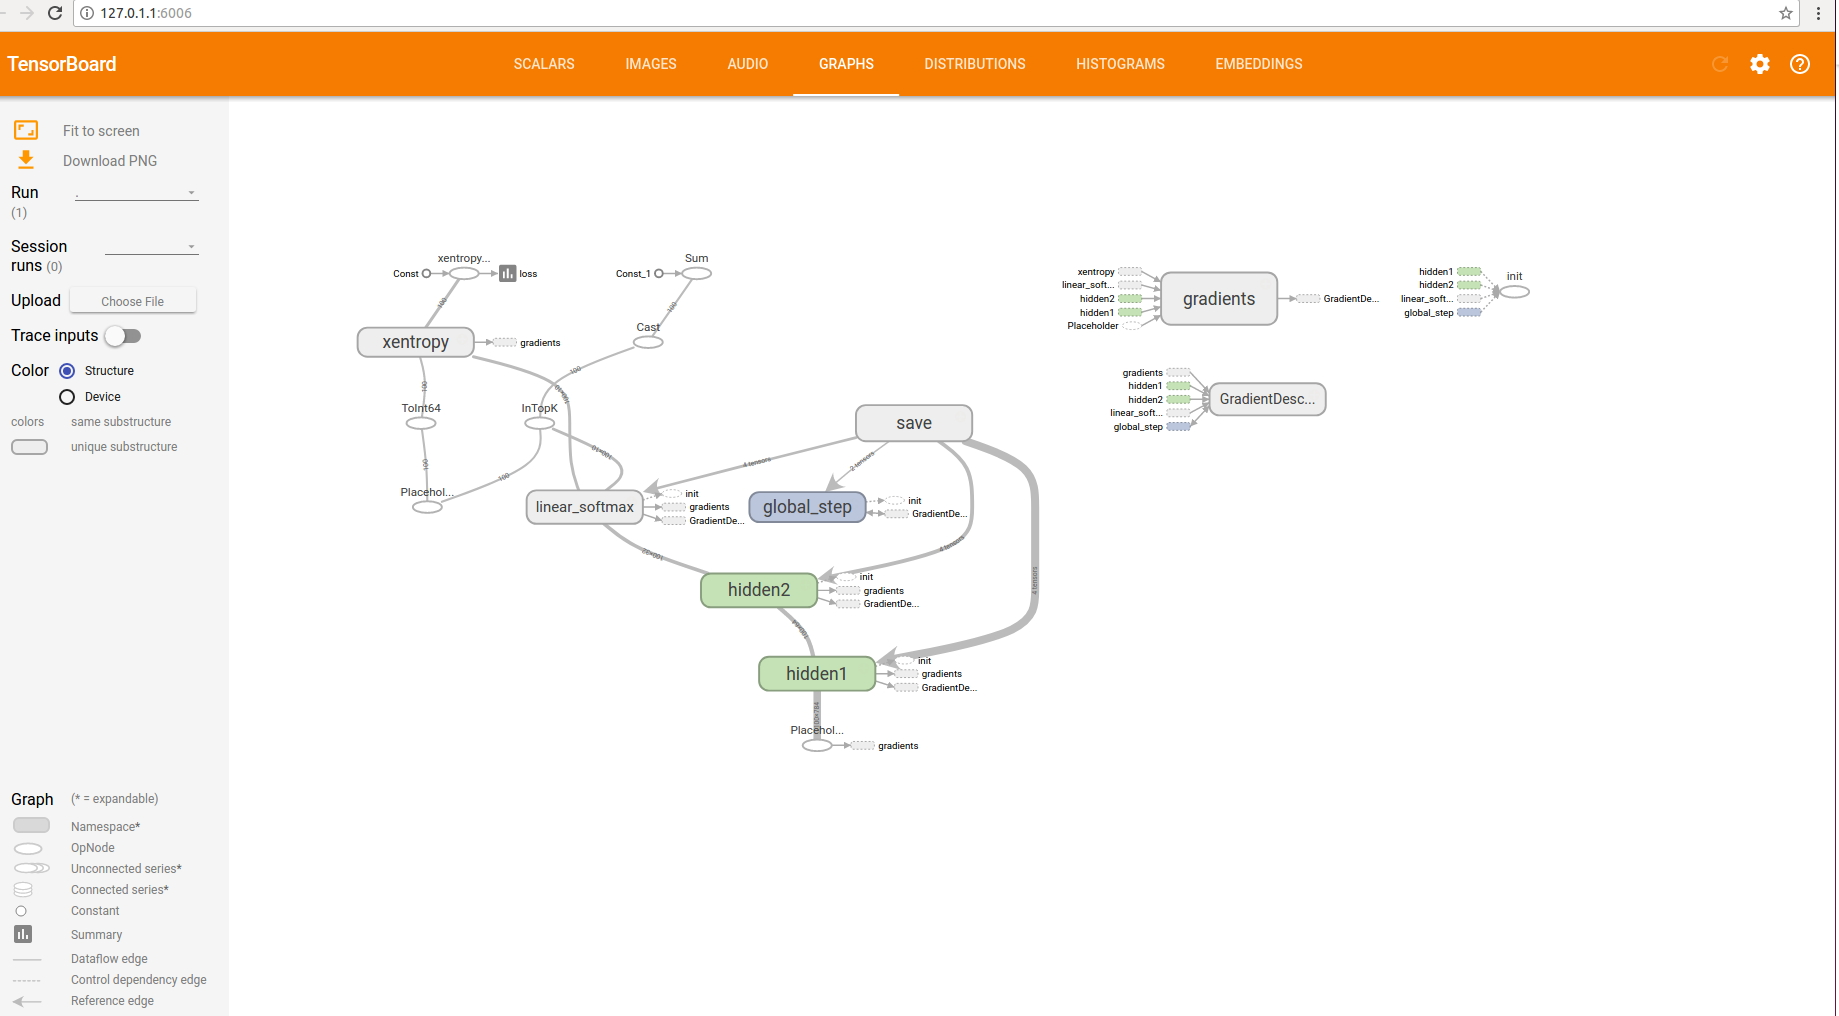

In [28]:
from IPython.display import Image
Image(filename = 'FC_TB.jpg')